In [2]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import warnings # отключим предупреждения Anaconda
warnings.simplefilter('ignore')
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' #графики в svg выглядят более четкими
from pylab import rcParams #увеличим дефолтный размер графиков
rcParams['figure.figsize'] = 8, 5
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import plotly.graph_objects as go
init_notebook_mode(connected=True)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve

pd.options.display.float_format = '{:,.1f}'.format # Отображение чисел float с запятыми и 1 знаком после точки

ошибка прогноза любой модели вида  складывается из:

1 квадрата смещения:  – средняя ошибка по всевозможным наборам данных;
2 дисперсии:  – вариативность ошибки, то, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных;
3 неустранимой ошибки: .

In [ ]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.legend();

In [ ]:
data = pd.read_csv('microchip_tests.txt', header=None, names = ('test1', 'test2', 'released'))

In [ ]:
data.head()

In [ ]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

In [ ]:
plt.scatter(X[y ==1, 0], X[y == 1, 1], c = 'green', label = 'Выпущен')
plt.scatter(X[y ==0, 0], X[y == 0, 1], c = 'red', label = 'Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title("2 теста микрочипов")
plt.legend()

In [ ]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

# каждой точке в сетке [x_min, m_max]x[y_min, y_max]
# ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

In [ ]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

чем больше параметр C, тем более сложные зависимости в данных может восстанавливать модель (интуитивно  соответствует "сложности" модели (model capacity)). Это гиперпараметр модели, который настраивается на кросс-валидации, как и max_depth для дерева.

In [ ]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

C = 1000
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

In [ ]:
reviews_train = load_files("aclImdb\\train")
text_train, y_train = reviews_train.data, reviews_train.target

print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))


reviews_test = load_files("aclImdb\\test")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

In [ ]:
cv = CountVectorizer()
cv.fit(text_train)

print(len(cv.vocabulary_)) #74849

print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

In [ ]:
X_train = cv.transform(text_train)
X_test = cv.transform(text_test)

In [ ]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)
print(round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3))

In [ ]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
# get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
# plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [ ]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
    color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
    color='red', label='test')
    plt.legend();

In [ ]:
visualize_coefficients(logit, cv.get_feature_names())

In [7]:
data = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
d = {'no' : False, 'yes' : True}
data['international plan'] = data['international plan'].map(d)
data['voice mail plan'] = data['voice mail plan'].map(d)

In [8]:
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,False,True,25,265.1,110,45.1,...,99,16.8,244.7,91,11.0,10.0,3,2.7,1,False
1,OH,107,415,371-7191,False,True,26,161.6,123,27.5,...,103,16.6,254.4,103,11.4,13.7,3,3.7,1,False
2,NJ,137,415,358-1921,False,False,0,243.4,114,41.4,...,110,10.3,162.6,104,7.3,12.2,5,3.3,0,False
3,OH,84,408,375-9999,True,False,0,299.4,71,50.9,...,88,5.3,196.9,89,8.9,6.6,7,1.8,2,False
4,OK,75,415,330-6626,True,False,0,166.7,113,28.3,...,122,12.6,186.9,121,8.4,10.1,3,2.7,3,False


In [10]:
y = data['churn'].astype('int').values
X = data.drop('churn', axis=1).values

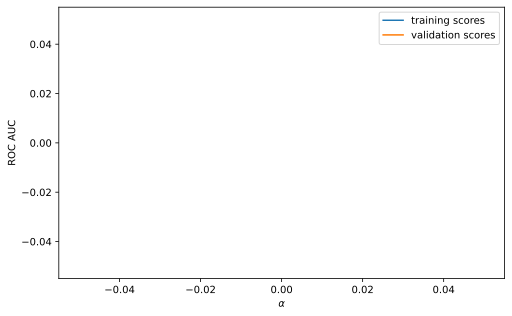

In [12]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), 
('sgd_logit', sgd_logit)])
val_train, val_test = validation_curve(logit_pipe, X, y,
'sgd_logit__alpha', alphas, cv=5,
scoring='roc_auc')

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend();